# Korean Hate Speech Detection

From Kaggle competition: https://www.kaggle.com/c/korean-hate-speech-detection

Main reference: 
- [6) 네이버 영화 리뷰 감성 분류하기(Naver Movie Review Sentiment Analysis) - 딥 러닝을 이용한 자연어 처리 입문](https://wikidocs.net/44249)
- [텐서플로 2와 머신러닝으로 시작하는 자연어 처리](https://www.aladin.co.kr/shop/wproduct.aspx?ItemId=251521480)

## 0. Import Required Libraries

In [1]:
# For M1 macs: https://cpuu.postype.com/post/9091007
#from tensorflow.python.framework.ops import disable_eager_execution
#disable_eager_execution()
#from tensorflow.python.compiler.mlcompute import mlcompute
#mlcompute.set_mlc_device(device_name='gpu')

%reset

import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
import tensorflow as tf
from tqdm import tqdm
import re

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.python.ops.math_ops import reduce_prod

from konlpy.tag import Mecab
from konlpy.tag import Okt

%matplotlib inline

SEED_NUM = 417
tf.random.set_seed(SEED_NUM)

DATA_PATH = "/Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/"


## 1. Load & Check Dataset

### Load dataset

In [2]:
df_train = pd.read_csv(DATA_PATH + '/dataset/train.hate.csv')
df_validation = pd.read_csv(DATA_PATH + '/dataset/dev.hate.csv')
df_test = pd.read_csv(DATA_PATH + '/dataset/test.hate.no_label.csv')

dataframes = [df_train, df_validation, df_test]

### Check dataset

In [3]:
for df in dataframes:
    print(df.head)

<bound method NDFrame.head of                                                comments label
0     (현재 호텔주인 심정) 아18 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속...  hate
1     ....한국적인 미인의 대표적인 분...너무나 곱고아름다운모습...그모습뒤의 슬픔을...  none
2     ...못된 넘들...남의 고통을 즐겼던 넘들..이젠 마땅한 처벌을 받아야지..,그래...  hate
3                    1,2화 어설펐는데 3,4화 지나서부터는 갈수록 너무 재밌던데  none
4     1. 사람 얼굴 손톱으로 긁은것은 인격살해이고2. 동영상이 몰카냐? 메걸리안들 생각...  hate
...                                                 ...   ...
7891                                      힘내세요~ 응원합니다!!  none
7892                             힘내세요~~삼가 고인의 명복을 빕니다..  none
7893                              힘내세용 ^^ 항상 응원합니닷 ^^ !  none
7894  힘내소...연기로 답해요.나도 53살 인데 이런일 저런일 다 있더라구요.인격을 믿습...  none
7895                                 힘들면 관뒀어야지 그게 현명한거다  none

[7896 rows x 2 columns]>
<bound method NDFrame.head of                                               comments      label
0                          송중기 시대극은 믿고본다. 첫회 신선하고 좋았다.       none
1                                     

31.0


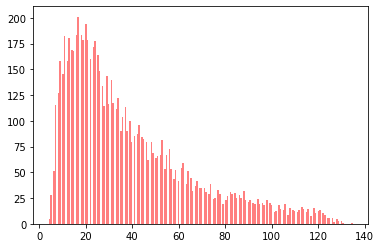

In [4]:
data_length = df_train['comments'].astype(str).apply(len)

plt.hist(data_length, bins=200, alpha=0.5, color='r', label='word')

print(np.median(data_length))

## 2. Data Preprocessing

### 2.1 Remove unwanted part from comment

1. 각종 이모티콘, 특수문자 등을 제거하여 효율성 증대
2. 반복되는 문자를 동일하게 처리해서 효율성 증대 ex. ㅋㅋㅋㅋㅋㅋㅋㅋ -> ㅋㅋ

In [5]:
import re

regular_expression1 = "[^a-zA-Z0-9ㄱ-ㅎㅏ-ㅣ가-힣 ]"
regular_expression2 = "ㅋ{1,}"
regular_expression3 = "ㅎ{1,}"
regular_expression4 = "ㅜ{1,}"
regular_expression5 = "ㅠ{1,}"
regular_expression6 = "[a-zA-Z]{1,}"
regular_expression7 = "[0-9]{1,}"


for df in dataframes:
    df['comments'] = df['comments'].str.replace(regular_expression1, "")
    df['comments'] = df['comments'].str.replace(regular_expression2, "ㅋㅋ")
    df['comments'] = df['comments'].str.replace(regular_expression3, "ㅎㅎ")
    df['comments'] = df['comments'].str.replace(regular_expression4, "ㅜㅜ")
    df['comments'] = df['comments'].str.replace(regular_expression5, "ㅠㅠ")
    df['comments'] = df['comments'].str.replace(regular_expression6, "ENG")
    df['comments'] = df['comments'].str.replace(regular_expression7, "NUM")
    
    print(df.head)

<bound method NDFrame.head of                                                comments label
0     현재 호텔주인 심정 아NUM 난 마른하늘에 날벼락맞고 호텔망하게생겼는데 누군 계속 ...  hate
1      한국적인 미인의 대표적인 분너무나 곱고아름다운모습그모습뒤의 슬픔을 미처 알지못했네요ㅠㅠ  none
2     못된 넘들남의 고통을 즐겼던 넘들이젠 마땅한 처벌을 받아야지그래야 공정한 사회지심은...  hate
3                    NUM화 어설펐는데 NUM화 지나서부터는 갈수록 너무 재밌던데  none
4     NUM 사람 얼굴 손톱으로 긁은것은 인격살해이고NUM 동영상이 몰카냐 메걸리안들 생...  hate
...                                                 ...   ...
7891                                         힘내세요 응원합니다  none
7892                                 힘내세요삼가 고인의 명복을 빕니다  none
7893                                   힘내세용  항상 응원합니닷    none
7894     힘내소연기로 답해요나도 NUM살 인데 이런일 저런일 다 있더라구요인격을 믿습니다홨팅  none
7895                                 힘들면 관뒀어야지 그게 현명한거다  none

[7896 rows x 2 columns]>
<bound method NDFrame.head of                                               comments      label
0                            송중기 시대극은 믿고본다 첫회 신선하고 좋았다       none
1                                     

### 2.2 Spell check

인터넷 댓글이기 때문에, 오타가 많으며 맞춤법이 정확하지 않아 토큰화가 제대로 되지 않는 경우가 있다고 판단했음.

이에 따라, 맞춤법 교정을 진행

단점 및 부작용
- 제대로 교정되지 않을 수 있음
- 인터넷 유행어나 신조어 등이 제대로 분석되지 않을 수 있음
- 시간이 오래 걸림


라이브러리 이용: https://github.com/ssut/py-hanspell

In [6]:
from hanspell import spell_checker

for df in dataframes:
    df['checked_comments'] = [None] * df.shape[0]

    for i in tqdm(range(0, df.shape[0])):
        result = spell_checker.check(df['comments'][i])
        df['checked_comments'][i] = result.checked

    print(df['checked_comments'])

  0%|          | 0/471 [00:00<?, ?it/s]0       현재 호텔 주인 심정 아 NUM 난 마른하늘에 날벼락 맞고 호텔 망하게 생겼는데 누...
1       한국적인 미인의 대표적인 분 너무나 곱고 아름다운 모습 그 모습 뒤의 슬픔을 미처 ...
2       못된 놈들 남의 고통을 즐겼던 놈들 이젠 마땅한 처벌을 받아야지 그래야 공정한 사회...
3                    NUM 화 어설펐는데 NUM 화 지나서부터는 갈수록 너무 재밌던데
4       NUM 사람 얼굴 손톱으로 긁은 것은 인격 살해이고 NUM 동영상이 몰카냐 에 걸리...
                              ...                        
7891                                           힘내세요 응원합니다
7892                                  힘내세요 삼가 고인의 명복을 빕니다
7893                                     힘내세요  항상 응원합니다  
7894    힘내소 연기로 답해요 나도 NUM 살인데 이런 일 저런 일 다 있더라고요 인격을 믿...
7895                                  힘들면 관뒀어야지 그게 현명한 거다
Name: checked_comments, Length: 7896, dtype: object
  0%|          | 3/974 [00:00<00:38, 25.09it/s]0                            송중기 시대극은 믿고 본다 첫 회 신선하고 좋았다
1                                               지현우 나쁜 놈
2      알바쓰고많이만들면되지 돈 욕심 없으면 골목식당 왜 나온 거야 긴 댕기게 나하고 산에...
3                                         설마 ㅈ 현정 작가 

### 2.3 Tokenize

데이터를 토큰화해 모델에 입력으로 사용하므로, 한국어 형태소 분석기를 통해 토큰화

조사 등의 불용어를 정의하고 이를 제거

In [7]:
okt = Okt()

stopwords = set(['뭐','으면','을','의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다', '은', '는', '이', '가', '하', '아', '것', '들', '의', '있', '되', '수', '보', '주', '등', '한', '거', '다', '적', '인', '고', '이고', '라고', '면', '이다', '로', ])

for df in dataframes:
    df['tokenized_comments'] = [None] * df.shape[0]

    for i in tqdm(range(0, df.shape[0])):
        #print('Comment_' + str(i+1) + ':          ' + df['comments'][i])
        #print('Comment_' + str(i+1) + '_Refined:  ' + result.checked)
        tmp = okt.morphs(df['checked_comments'][i], stem=True)
        result = []
        for word in tmp:
            if word == "ENG":
                word = "<ENG>"
            if word == "NUM":
                word = "<NUM>"

            if word not in stopwords:
                result.append(word)

        df['tokenized_comments'][i] = result
    
    print(df['tokenized_comments'])
    

 19%|█▉        | 89/471 [00:00<00:00, 882.86it/s]0       [현재, 호텔, 주인, 심정, <NUM>, 난, 마른하늘, 날벼락, 맞다, 호텔, ...
1       [한국, 미인, 대표, 분, 너무나, 곱, 아름답다, 모습, 그, 모습, 뒤, 슬픔...
2       [못, 되다, 놈, 남, 고통, 즐기다, 놈, 젠, 마땅하다, 처벌, 받다, 그, ...
3           [<NUM>, 화, 어설프다, <NUM>, 화, 지나다, 갈수록, 너무, 재밌다]
4       [<NUM>, 사람, 얼굴, 손톱, 긁다, 인격, 살해, <NUM>, 동영상, 몰카...
                              ...                        
7891                                            [힘내다, 응원]
7892                               [힘내다, 삼가다, 고인, 명복, 비다]
7893                                        [힘내다, 항상, 응원]
7894    [힘내다, 연기, 답, 나다, <NUM>, 살, 인데, 이렇다, 일, 저런, 일, ...
7895                               [힘들다, 관, 두다, 그게, 현명하다]
Name: tokenized_comments, Length: 7896, dtype: object
  9%|▉         | 87/974 [00:00<00:01, 867.06it/s]0                     [송중기, 시대극, 믿다, 보다, 첫, 회, 신선하다, 좋다]
1                                          [지현우, 나쁘다, 놈]
2      [알바, 쓰다, 많이, 만, 되다, 돈, 욕심, 없다, 골목, 식당, 왜, 나오다,...
3                                   [설마

### 2.4 Integer encoding

In [8]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df_train['tokenized_comments'])

sequences = {}

sequences['train'] = tokenizer.texts_to_sequences(df_train['tokenized_comments'])
sequences['validation'] = tokenizer.texts_to_sequences(df_validation['tokenized_comments'])
sequences['test'] = tokenizer.texts_to_sequences(df_test['tokenized_comments'])

### 2.5 Make vocabulary

In [9]:
vocab = tokenizer.word_index
vocab["<PAD>"] = 0
vocab["<NUM>"] = -1
vocab["<ENG>"] = -2
vocab["<...>"] = -3

vocab_size = len(vocab)

### 2.6 Padding for each sequences

In [10]:
MAX_SEQUENCE_LENGTH = 30

inputs = {}
labels = {}

inputs['train'] = pad_sequences(sequences['train'], maxlen = MAX_SEQUENCE_LENGTH, padding='post')
inputs['validation'] = pad_sequences(sequences['validation'], maxlen = MAX_SEQUENCE_LENGTH, padding='post')
inputs['test'] = pad_sequences(sequences['test'], maxlen = MAX_SEQUENCE_LENGTH, padding='post')

In [11]:
def show_sequences(line_num, df='train'):
    array_num = line_num - 2
    if df == 'train':
        print(df_train['tokenized_comments'][array_num], inputs['train'][array_num])
    else:
        print(df_test['tokenized_comments'][array_num], inputs['test'][array_num])

show_sequences(3, 'train')
show_sequences(626, 'train')
show_sequences(605, 'test')
show_sequences(319, 'test')

['한국', '미인', '대표', '분', '너무나', '곱', '아름답다', '모습', '그', '모습', '뒤', '슬픔', '미처', '알다', 'ㅠㅠ'] [ 125 1357  901  115 2035 1358  702  243   33  243  424 2694 5955   47
   35    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
['관상', '과학', '알', '지'] [1424 2750  154   46    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
['관상', '안', '좋다'] [1424    6    9    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]
['전라도', '문제', '전라도', '과학', 'ㅡㅡ'] [ 510  132  510 2750  195    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0]


### 2.7 Modify text label data to integers

In [12]:
def convert(label):
    if label == "hate":
        return 2
    if label == "offensive":
        return 1
    if label == "none":
        return 0

print(type(df_train['label'][234]))
print(df_train['label'][234])
print(convert(df_train['label'][234]))

<class 'str'>
offensive
1


In [13]:
labels['train'] = [None] * len(df_train['label'])
labels['validation'] = [None] * len(df_validation['label'])

for i in tqdm(range(0, len(df_train['label']))):
    labels['train'][i] = convert(df_train['label'][i])
    
for i in tqdm(range(0, len(df_validation['label']))):
    labels['validation'][i] = convert(df_validation['label'][i])

100%|██████████| 471/471 [00:00<00:00, 206752.19it/s]


## 3. Model - LSTM

### 3.1 Define hyperparameter

In [14]:
model_name = 'hate_classifier'
BATCH_SIZE = 50
NUM_EPOCHS = 30

kargs = {'model_name': model_name,
        'vocab_size': vocab_size,
        'embedding_dimension': 100,
        'dropout_rate': 0.25,
        'filter_size': 50,
        'conv1_kernel_size': 2,
        'conv2_kernel_size': 3,
        'lstm_dimension': 100,
        'dense1_dimension': 100,
        'dense2_dimension': 20,
        'output_dimension': 3}

### 3.2 Model implementation

In [42]:
class HATEclassifier(tf.keras.Model):
    def __init__(self, **kargs):
        super(HATEclassifier, self).__init__(name=kargs['model_name'])
        initializer = tf.keras.initializers.HeNormal()

        self.embedding = tf.keras.layers.Embedding(input_dim=kargs['vocab_size'], output_dim=kargs['embedding_dimension'])
        self.dropout = tf.keras.layers.Dropout(kargs['dropout_rate'])

        self.conv1 = tf.keras.layers.Conv1D(filters=kargs['filter_size'], kernel_size=kargs['conv1_kernel_size'], 
                                            padding='same', activation='relu')
        self.conv2 = tf.keras.layers.Conv1D(filters=kargs['filter_size'], kernel_size=kargs['conv1_kernel_size'], 
                                            padding='same', activation='relu')
        self.conv3 = tf.keras.layers.Conv1D(filters=kargs['filter_size'], kernel_size=kargs['conv2_kernel_size'], 
                                            padding='same', activation='relu')
        self.conv4 = tf.keras.layers.Conv1D(filters=kargs['filter_size'], kernel_size=kargs['conv2_kernel_size'], 
                                            padding='same', activation='relu')
        self.pooling = tf.keras.layers.MaxPool1D()

        self.lstm1 = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm2 = tf.keras.layers.LSTM(kargs['lstm_dimension'], return_sequences=True)
        self.lstm_last = tf.keras.layers.LSTM(kargs['lstm_dimension'])
        
        self.fc1 = tf.keras.layers.Dense(units=kargs['dense1_dimension'], activation='relu', kernel_initializer=initializer)
        self.fc2 = tf.keras.layers.Dense(units=kargs['dense2_dimension'], activation='relu', kernel_initializer=initializer)

        self.fc_last = tf.keras.layers.Dense(units=kargs['output_dimension'], activation='softmax', kernel_initializer=initializer)

    def call(self, x):
        x = self.embedding(x)
        x = self.dropout(x)

        x = self.conv1(x)
        x = self.conv2(x)
        x = self.pooling(x)
        x = self.conv3(x)
        x = self.conv4(x)
        x = self.pooling(x)

        x = self.lstm1(x)
        x = self.lstm2(x)
        x = self.lstm_last(x)
        x = self.dropout(x)

        x = self.fc1(x)
        x = self.dropout(x)
        x = self.fc2(x)
        x = self.dropout(x)

        x = self.fc_last(x)

        return x

### 3.3 Generate model instance

In [43]:
model = HATEclassifier(**kargs)
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(),
            metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

## 4. Learning

### 4.1 Learning

In [44]:
#from tensorflow.python.ops.math_ops import reduce_prod
#from tensorflow.math import reduce_prod

earlystop_callback = tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', min_delta=1e-4, patience=5)

checkpoint_path = DATA_PATH + model_name + '/weights.h5'
checkpoint_dir = os.path.dirname(checkpoint_path)

if os.path.exists(checkpoint_dir):
    pass
else:
    os.makedirs(checkpoint_dir, exist_ok=True)

checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(checkpoint_path, monitor='val_accuracy', verbose=1, save_best_only=True, save_weights_only=True)

labels['train'] = np.asarray(labels['train']).astype(np.int8)
labels['validation'] = np.asarray(labels['validation']).astype(np.int8)

history = model.fit(inputs['train'], labels['train'], batch_size=BATCH_SIZE, epochs=NUM_EPOCHS, 
                    validation_data=(inputs['validation'], labels['validation']), 
                    callbacks=[earlystop_callback, checkpoint_callback])

model.summary()

Epoch 1/30
158/158 [==============================] - 4s 21ms/step - loss: 1.0834 - accuracy: 0.4157 - val_loss: 1.1092 - val_accuracy: 0.3397

Epoch 00001: val_accuracy improved from -inf to 0.33970, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/hate_classifier/weights.h5
Epoch 2/30
158/158 [==============================] - 3s 18ms/step - loss: 1.0578 - accuracy: 0.4433 - val_loss: 1.0942 - val_accuracy: 0.3418

Epoch 00002: val_accuracy improved from 0.33970 to 0.34183, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/hate_classifier/weights.h5
Epoch 3/30
158/158 [==============================] - 3s 20ms/step - loss: 1.0267 - accuracy: 0.4625 - val_loss: 0.9772 - val_accuracy: 0.4883

Epoch 00003: val_accuracy improved from 0.34183 to 0.48832, saving model to /Users/choijuhwan/Workspace/Git_Repos/korean-hate-speech-detection/hate_classifier/weights.h5
Epoch 4/30
158/158 [==============================] - 3s 20ms

## 5. Show results

### 5.1 Plot results & validation score

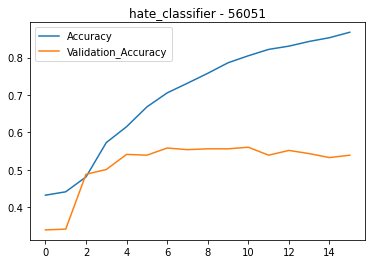

In [45]:
import matplotlib.pyplot as plt

score = np.max(history.history['val_accuracy'])
score = np.round(score, 5)
score = str(score)
score = score[2:]

if len(score) == 4:
    score.append("0")

plt.plot(history.history['accuracy'], label = "Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation_Accuracy")

plt.title(kargs['model_name'] + " - " + str(score))
plt.legend()
plt.show()

## 6. Predictions

### 6.1 Predict for test inputs

In [46]:
model.load_weights(os.path.join(checkpoint_path))
predictions = model.predict(inputs['test'], batch_size=BATCH_SIZE)

## 7. Export result to csv format 

In [47]:
df_export = pd.read_csv(DATA_PATH + '/dataset/test.hate.no_label.csv')

df_export['label'] = [None] * predictions.shape[0]

for i in tqdm(range(0, predictions.shape[0])):
    df_export['label'][i] = np.argmax(predictions[i])

df_export = pd.DataFrame(df_export, columns = ['comments', 'label'])

df_export.to_csv(DATA_PATH + model_name + '/export_' + score + '.csv', sep=',', index=False)
df_export

100%|██████████| 974/974 [00:00<00:00, 4332.05it/s]


,comments,label
0,ㅋㅋㅋㅋ 그래도 조아해주는 팬들 많아서 좋겠다 ㅠㅠ 니들은 온유가 안만져줌 ㅠㅠ,1
1,둘다 넘 좋다~행복하세요,1
2,근데 만원이하는 현금결제만 하라고 써놓은집 우리나라에 엄청 많은데,1
3,원곡생각하나도 안나고 러블리즈 신곡나온줄!!! 너무 예쁘게 잘봤어요,0
4,장현승 얘도 참 이젠 짠하다...,2
...,...,...
969,대박 게스트... 꼭 봐야징~ 컨셉이 바뀌니깐 재미지넹,2
970,성형으로 다 뜯어고쳐놓고 예쁜척. 성형 전 니 얼굴 다 알고있다. 순자처럼 된장냄새...,0
971,분위기는 비슷하다만 전혀다른 전개던데 무슨ㅋㅋㄱ 우리나라사람들은 분위기만 비슷하면 ...,0
972,입에 손가릭이 10개 있으니 징그럽다,1
